# 8章 MNISTを使った数字認識

In [87]:
import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.nn as nn
import torchvision.datasets as datasets
import torchvision.transforms as transforms
import torch.optim as optim
from torchviz import make_dot
from tqdm import tqdm


/home/sota/.local/lib/python3.8/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 38306 (\N{CJK UNIFIED IDEOGRAPH-95A2}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/home/sota/.local/lib/python3.8/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 25968 (\N{CJK UNIFIED IDEOGRAPH-6570}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


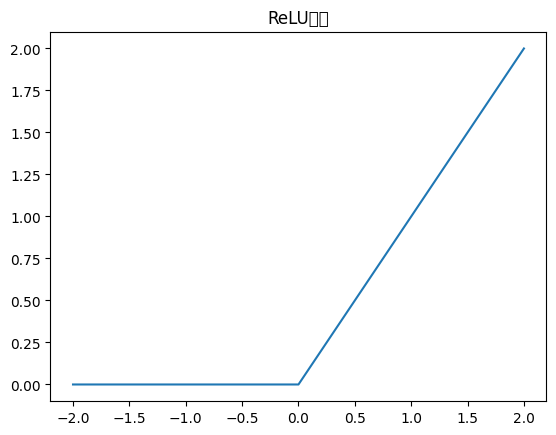

In [88]:
relu = nn.ReLU()
x_np = np.arange(-2, 2.1, 0.25)
x    = torch.tensor(x_np).float()
y = relu(x)

plt.plot(x.data, y.data)
plt.title('ReLU関数')
plt.show()

In [89]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)# cudaが利用可能だと0

cuda:0


## 8.8 データ準備1(データセットによる読み込み)

In [90]:
data_root = './data'
train_set0 = datasets.MNIST(
    root = data_root,
    train = True,
    download = True
)
!ls -lR ./data/MNIST

83403.43s - pydevd: Sending message related to process being replaced timed-out after 5 seconds


./data/MNIST:
total 4
drwxrwxr-x 2 sota sota 4096 12月 22 23:12 raw

./data/MNIST/raw:
total 65012
-rw-rw-r-- 1 sota sota  7840016 12月 22 23:12 t10k-images-idx3-ubyte
-rw-rw-r-- 1 sota sota  1648877 12月 22 23:12 t10k-images-idx3-ubyte.gz
-rw-rw-r-- 1 sota sota    10008 12月 22 23:12 t10k-labels-idx1-ubyte
-rw-rw-r-- 1 sota sota     4542 12月 22 23:12 t10k-labels-idx1-ubyte.gz
-rw-rw-r-- 1 sota sota 47040016 12月 22 23:12 train-images-idx3-ubyte
-rw-rw-r-- 1 sota sota  9912422 12月 22 23:12 train-images-idx3-ubyte.gz
-rw-rw-r-- 1 sota sota    60008 12月 22 23:12 train-labels-idx1-ubyte
-rw-rw-r-- 1 sota sota    28881 12月 22 23:12 train-labels-idx1-ubyte.gz


In [91]:
print("データ件数：", len(train_set0))
image, label = train_set0[0]
print("入力データの型：", type(image))
print("正解データの型：", type(label))

データ件数： 60000
入力データの型： <class 'PIL.Image.Image'>
正解データの型： <class 'int'>


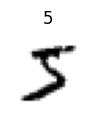

In [92]:
plt.figure(figsize=(1,1))
plt.title(f'{label}')
plt.imshow(image, cmap="gray_r")
plt.axis("off")
plt.show()

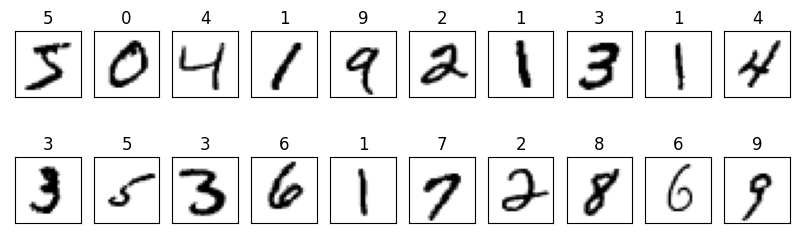

In [93]:
plt.figure(figsize=(10,3))
for i in range(20):
    ax = plt.subplot(2,10,i+1)
    image, label = train_set0[i]
    plt.imshow(image, cmap="gray_r")
    ax.set_title(f'{label}')
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()

## 8.9 データ準備2(Transformsによるデータ前処理)

In [94]:
# ToTensor：入力データの形式をPyTorchで扱えるテンソル形式に変換する
transform1 = transforms.Compose([
    transforms.ToTensor(),
])
train_set1 = datasets.MNIST(
    root=data_root, train=True, download=True,
    transform = transform1
)

In [95]:
image, label = train_set1[0]
print("入力データの型：", type(image))
print("入力データのshape：", image.shape)
print("Min: ", image.data.min())
print("Max: ", image.data.max())

入力データの型： <class 'torch.Tensor'>
入力データのshape： torch.Size([1, 28, 28])
Min:  tensor(0.)
Max:  tensor(1.)


In [96]:
# データの範囲を[-1, 1]になるように正規化
# Normalize:X=(x-u)/σ（u=σ=0.5)
transform2 = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(0.5, 0.5),
])

train_set2 = datasets.MNIST(
    root = data_root, train=True, download=True, transform=transform2
)

image, label = train_set2[0]
print("入力データの型：", type(image))
print("入力データのshape：", image.shape)
print("Min: ", image.data.min())
print("Max: ", image.data.max())

入力データの型： <class 'torch.Tensor'>
入力データのshape： torch.Size([1, 28, 28])
Min:  tensor(-1.)
Max:  tensor(1.)


In [97]:
# Lambdaクラスを利用して１次元化
# テンソルではreshapeではなく、viewを用いる
transform3 = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(0.5, 0.5),
    transforms.Lambda(lambda x: x.view(-1)),
])

train_set3 = datasets.MNIST(
    root = data_root, train=True, download=True, transform=transform3
)

image, label = train_set3[0]
print("入力データの型: ", type(image))
print("入力データのshape: ", image.shape)
print("Min: ", image.data.min())
print("Max: ", image.data.max())

入力データの型:  <class 'torch.Tensor'>
入力データのshape:  torch.Size([784])
Min:  tensor(-1.)
Max:  tensor(1.)


In [98]:
# 最終的なデータセットの定義
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(0.5, 0.5),
    transforms.Lambda(lambda x: x.view(-1)),
])
train_set = datasets.MNIST(
    root = data_root, train=True, download=True, transform=transform
)
test_set = datasets.MNIST(
    root = data_root, train=False, download=True, transform=transform
)

## 8.10 データ準備3(データローダによるミニバッチ用データ生成)

In [99]:
from torch.utils.data import DataLoader
batch_size=500

train_loader = DataLoader(
    train_set, batch_size = batch_size,
    shuffle = True
)
test_loader = DataLoader(
    test_set, batch_size = batch_size,
    shuffle = False
)

In [100]:
print(len(train_loader))
for images, labels in train_loader:
    break

print(images.shape)
print(labels.shape)

120
torch.Size([500, 784])
torch.Size([500])


## 8.11 モデル定義

In [101]:
n_input = image.shape[0]
n_output = len(set(list(labels.data.numpy())))
n_hidden = 128
print(f'n_input: {n_input} n_hidden: {n_hidden} n_output: {n_output}')

n_input: 784 n_hidden: 128 n_output: 10


In [102]:
# モデルの定義
class Net(nn.Module):
    def __init__(self, n_input, n_output, n_hidden):
        super().__init__()
        self.l1 = nn.Linear(n_input, n_hidden)
        self.l2 = nn.Linear(n_hidden, n_output)
        self.relu = nn.ReLU(inplace=True)

    def forward(self, x):
        x1 = self.l1(x)
        x2 = self.relu(x1)
        x3 = self.l2(x2)
        return x3


In [103]:
torch.manual_seed(123)
torch.cuda.manual_seed(123)

net = Net(n_input, n_output, n_hidden)
net = net.to(device)
# net = Net(n_input, n_output, n_hidden).to(device)

In [104]:
# 学習率
lr = 0.01

# アルゴリズム: 勾配降下法
optimizer = torch.optim.SGD(net.parameters(), lr=lr)

# 損失関数： 交差エントロピー関数
criterion = nn.CrossEntropyLoss()

In [105]:
for parameter in net.named_parameters():
    print(parameter)

('l1.weight', Parameter containing:
tensor([[-0.0146,  0.0012, -0.0177,  ...,  0.0277,  0.0200,  0.0315],
        [ 0.0184, -0.0322,  0.0175,  ...,  0.0089, -0.0028, -0.0033],
        [ 0.0092,  0.0261,  0.0075,  ...,  0.0061,  0.0267, -0.0258],
        ...,
        [ 0.0235, -0.0026, -0.0129,  ...,  0.0322, -0.0059, -0.0169],
        [-0.0328, -0.0258,  0.0124,  ..., -0.0049,  0.0006,  0.0334],
        [ 0.0187, -0.0076, -0.0202,  ...,  0.0325, -0.0159, -0.0240]],
       device='cuda:0', requires_grad=True))
('l1.bias', Parameter containing:
tensor([ 0.0325, -0.0298,  0.0013,  0.0199,  0.0268, -0.0248, -0.0172, -0.0355,
         0.0122, -0.0048,  0.0214,  0.0202, -0.0243,  0.0015, -0.0276,  0.0296,
         0.0341, -0.0228,  0.0230,  0.0347, -0.0091, -0.0346,  0.0206, -0.0060,
         0.0329,  0.0047,  0.0180,  0.0101,  0.0177, -0.0309,  0.0228, -0.0224,
         0.0321,  0.0179,  0.0321,  0.0184,  0.0219, -0.0089,  0.0310, -0.0039,
        -0.0074, -0.0317,  0.0192, -0.0021,  0.0190

In [106]:
print(net)

Net(
  (l1): Linear(in_features=784, out_features=128, bias=True)
  (l2): Linear(in_features=128, out_features=10, bias=True)
  (relu): ReLU(inplace=True)
)


## 8.12 勾配降下法

In [107]:
for images, labels in train_loader:
    break
inputs = images.to(device)
labels = labels.to(device)
outputs = net(inputs)
print(outputs)

tensor([[-0.2908, -0.0540,  0.0845,  ...,  0.0779,  0.1828,  0.1080],
        [-0.2764, -0.3271, -0.1788,  ...,  0.1037,  0.1030, -0.0235],
        [-0.3289, -0.0409,  0.1447,  ...,  0.3945,  0.2317,  0.1213],
        ...,
        [-0.4067, -0.0062,  0.1470,  ...,  0.0346,  0.1045,  0.1304],
        [-0.3684, -0.2211,  0.1907,  ...,  0.0544,  0.2114,  0.1275],
        [-0.2524, -0.2597,  0.1427,  ...,  0.0983,  0.1258,  0.0972]],
       device='cuda:0', grad_fn=<AddmmBackward0>)


2.3259596824645996


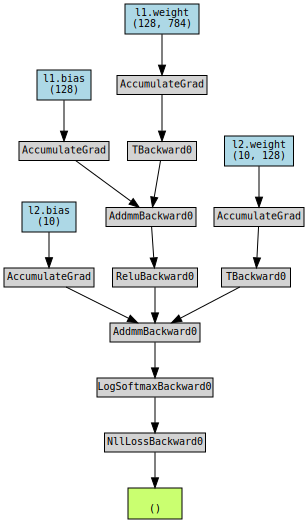

In [108]:
# 損失計算
loss = criterion(outputs, labels)
print(loss.item())
make_dot(loss, params=dict(net.named_parameters()))

In [109]:
# 乱数の固定化
torch.manual_seed(123)
torch.cuda.manual_seed(123)

# 学習率
lr = 0.01
# モデル初期化
net = Net(n_input, n_output, n_hidden).to(device)
# 損失関数：交差エントロピー関数
criterion = nn.CrossEntropyLoss()
# 最適化関数
optimizer = optim.SGD(net.parameters(), lr=lr)
# 繰り返し回数
num_epochs = 100
# 評価関数結果記録用
history = np.zeros((0,5))


In [133]:
# 繰り返し計算メインループ
for epoch in range(num_epochs):
    train_acc, train_loss = 0, 0
    val_acc, val_loss = 0, 0
    n_train, n_test = 0, 0

    # 訓練フェーズ
    for inputs, labels in tqdm(train_loader):
        n_train += len(labels)
        # GPUへ転送
        inputs = inputs.to(device)
        labels = labels.to(device)
        # 勾配の初期化
        optimizer.zero_grad()
        # 予測計算
        outputs = net(inputs)
        # 損失計算
        loss = criterion(outputs, labels)
        # 勾配計算
        loss.backward()
        # パラメータ修正
        optimizer.step()
        # 予測ラベル導出
        predicted = torch.max(outputs, 1)[1]
        # 損失と精度の計算
        train_loss += loss.item()
        train_acc += (predicted == labels).sum().item() 

    # 予測フェーズ
    for inputs_test, labels_test in test_loader:
        n_test += len(labels_test)
        inputs_test = inputs_test.to(device)
        labels_test = labels_test.to(device)

        # 予測計算
        outputs_test = net(inputs_test)

        # 損失関数
        loss_test = criterion(outputs_test, labels_test)

        # 予測データ導出
        predicted_test = torch.max(outputs_test, 1)[1]

        # 損失と制度の計算
        val_loss += loss_test.item()
        val_acc += (predicted_test == labels_test).sum().item()

    # 評価値の算出・記録
    train_acc = train_acc / n_train
    val_acc = val_acc / n_test
    train_loss = train_loss * batch_size / n_train
    val_loss = val_loss * batch_size / n_test
    print (f'Epoch [{epoch+1}/{num_epochs}], loss: {train_loss:.5f} acc: {train_acc:.5f} val_loss: {val_loss:.5f}, val_acc: {val_acc:.5f}')
    item = np.array([epoch+1 , train_loss, train_acc, val_loss, val_acc])
    history = np.vstack((history, item))
print(f'初期状態：損失：{history[0,3]:.5f}  精度：{history[0,4]:.5f}')
print(f'最終状態：損失：{history[-1,3]:.5f}  精度：{history[-1,4]:.5f}')

100%|██████████| 120/120 [00:03<00:00, 37.74it/s]


Epoch [1/100], loss: 2.32555 acc: 0.09587 val_loss: 2.32403, val_acc: 0.10020


100%|██████████| 120/120 [00:03<00:00, 38.26it/s]


Epoch [2/100], loss: 2.32555 acc: 0.09587 val_loss: 2.32403, val_acc: 0.10020


100%|██████████| 120/120 [00:03<00:00, 38.22it/s]


Epoch [3/100], loss: 2.32555 acc: 0.09587 val_loss: 2.32403, val_acc: 0.10020


100%|██████████| 120/120 [00:03<00:00, 38.14it/s]


Epoch [4/100], loss: 2.32555 acc: 0.09587 val_loss: 2.32403, val_acc: 0.10020


100%|██████████| 120/120 [00:03<00:00, 38.26it/s]


Epoch [5/100], loss: 2.32555 acc: 0.09587 val_loss: 2.32403, val_acc: 0.10020


100%|██████████| 120/120 [00:03<00:00, 38.01it/s]


Epoch [6/100], loss: 2.32555 acc: 0.09587 val_loss: 2.32403, val_acc: 0.10020


100%|██████████| 120/120 [00:03<00:00, 37.93it/s]


Epoch [7/100], loss: 2.32555 acc: 0.09587 val_loss: 2.32403, val_acc: 0.10020


100%|██████████| 120/120 [00:03<00:00, 38.56it/s]


Epoch [8/100], loss: 2.32555 acc: 0.09587 val_loss: 2.32403, val_acc: 0.10020


100%|██████████| 120/120 [00:03<00:00, 38.26it/s]


Epoch [9/100], loss: 2.32555 acc: 0.09587 val_loss: 2.32403, val_acc: 0.10020


100%|██████████| 120/120 [00:03<00:00, 38.23it/s]


Epoch [10/100], loss: 2.32555 acc: 0.09587 val_loss: 2.32403, val_acc: 0.10020


100%|██████████| 120/120 [00:03<00:00, 37.25it/s]


Epoch [11/100], loss: 2.32555 acc: 0.09587 val_loss: 2.32403, val_acc: 0.10020


100%|██████████| 120/120 [00:03<00:00, 38.22it/s]


Epoch [12/100], loss: 2.32555 acc: 0.09587 val_loss: 2.32403, val_acc: 0.10020


100%|██████████| 120/120 [00:03<00:00, 37.33it/s]


Epoch [13/100], loss: 2.32555 acc: 0.09587 val_loss: 2.32403, val_acc: 0.10020


100%|██████████| 120/120 [00:03<00:00, 38.35it/s]


Epoch [14/100], loss: 2.32555 acc: 0.09587 val_loss: 2.32403, val_acc: 0.10020


100%|██████████| 120/120 [00:03<00:00, 38.24it/s]


Epoch [15/100], loss: 2.32555 acc: 0.09587 val_loss: 2.32403, val_acc: 0.10020


 91%|█████████ | 109/120 [00:02<00:00, 38.08it/s]


KeyboardInterrupt: 

In [130]:
num_epochs

100